## Final Exam GSE 526

Load

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
#QuantReg:
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
df = pd.read_csv("/Users/jadenfix/Desktop/Graduate School Materials/micrometrics/paeco526_take_home_final.csv")
data = pd.DataFrame(df)
#print variable names in df:
print(data.columns)
covariates = [
    "dmage", "dmage2", "dmeduc", "mblack", "motherr", "mhispan", "dmar",
    "foreignb", "dfage", "dfeduc", "fblack", "fotherr", "fhispan", "alcohol",
    "drink", "adequac2", "adequac3", "tripre0", "tripre2", "tripre3", "nprevist",
    "first", "dlivord", "disllb", "pre4000", "plural", "diabete", "anemia",
    "cardiac", "chyper"
]

Index(['alcohol', 'anemia', 'cardiac', 'chyper', 'dbirwt', 'dfage', 'dfeduc',
       'diabete', 'disllb', 'dlivord', 'dmage', 'dmar', 'dmeduc', 'drink',
       'foreignb', 'nprevist', 'pre4000', 'tobacco', 'mblack', 'motherr',
       'mhispan', 'fblack', 'fotherr', 'fhispan', 'adequac2', 'adequac3',
       'tripre2', 'tripre3', 'tripre0', 'first', 'plural', 'dmage2'],
      dtype='object')


# Question 1

In [23]:
#adjusted for hc3
model1 = smf.ols("dbirwt ~ tobacco", data=data).fit(cov_type="HC3")
print("\n--- Q1: OLS Regression (Birth Weight on Tobacco) ---")
print(model1.summary())


--- Q1: OLS Regression (Birth Weight on Tobacco) ---
                            OLS Regression Results                            
Dep. Variable:                 dbirwt   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3038.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:24:19   Log-Likelihood:            -7.7665e+05
No. Observations:              100000   AIC:                         1.553e+06
Df Residuals:                   99998   BIC:                         1.553e+06
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

For the regression of birth weight on smoking to measure the true causal effect of smoking, mothers who smoke would have to be comparable to those who don’t in every other way, almost like smoking was randomly assigned. This usually isn’t realistic because smokers likely differ from non-smokers in other important ways, such as health habits, socioeconomic status, or stress levels, which also affect birth weight. Without controlling for these differences, the estimate mixes the real effect of smoking with other factors, making it unreliable as a purely causal measure.

# Question 2

In [24]:
formula_q2 = "dbirwt ~ tobacco + " + " + ".join(covariates)
model2 = smf.ols(formula_q2, data=data).fit(cov_type="HC3")
print("\n--- Q2: OLS Regression with Covariates ---")
print(model2.summary())


--- Q2: OLS Regression with Covariates ---
                            OLS Regression Results                            
Dep. Variable:                 dbirwt   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     463.6
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:24:21   Log-Likelihood:            -7.6975e+05
No. Observations:              100000   AIC:                         1.540e+06
Df Residuals:                   99968   BIC:                         1.540e+06
Df Model:                          31                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

For the coefficient on smoking to measure the true causal effect, controlling for the 30 covariates must remove all differences between smokers and non-smokers that affect birth weight. Although adding these covariates helps reduce bias (the effect went from –266 to –232 grams), it’s still likely that some unobserved differences remain, making the causal interpretation imperfect.

# Question 3

In [25]:

def balance_table(data, covariate_list, treatment, alpha=0.05):
    rows = []
    treated = data[data[treatment] == 1]
    control = data[data[treatment] == 0]
    for var in covariate_list:
        mean_treated = treated[var].mean()
        mean_control = control[var].mean()
        # Perform two-sample t-test (unequal variance)
        t_stat, p_val = stats.ttest_ind(treated[var].dropna(), control[var].dropna(), equal_var=False)
        diff = mean_treated - mean_control
        significant = "*" if p_val < alpha else ""
        rows.append({
            "Variable": var,
            "Mean (Treated)": mean_treated,
            "Mean (Control)": mean_control,
            "Difference": diff,
            "p-value": p_val,
            "Signif": significant
        })
    return pd.DataFrame(rows)

balance_tbl = balance_table(data, covariates, "tobacco")
print("\n--- Q3: Balance Table by Smoking Status ---")
print(balance_tbl)

# Count how many differences are statistically significant at the 5% level.
num_sig = (balance_tbl["Signif"] == "*").sum()
print("\nNumber of statistically significant differences at 5% level:", num_sig)



--- Q3: Balance Table by Smoking Status ---
    Variable  Mean (Treated)  Mean (Control)  Difference        p-value Signif
0      dmage       25.578382       27.396469   -1.818086   0.000000e+00      *
1     dmage2      683.009414      781.141828  -98.132414   0.000000e+00      *
2     dmeduc       11.888124       13.188123   -1.299999   0.000000e+00      *
3     mblack        0.133861        0.109495    0.024366   3.400487e-18      *
4    motherr        0.003329        0.018213   -0.014884  7.325558e-120      *
5    mhispan        0.016302        0.028530   -0.012228   1.156273e-27      *
6       dmar        0.425119        0.186512    0.238607   0.000000e+00      *
7   foreignb        0.016991        0.053125   -0.036134  2.263560e-181      *
8      dfage       28.480914       29.676710   -1.195796  1.770007e-109      *
9     dfeduc       12.019517       13.281258   -1.261741   0.000000e+00      *
10    fblack        0.150164        0.116894    0.033269   7.830802e-30      *
11   fo

The table shows significant differences between mothers who smoked and those who did not for 27 out of 30 characteristics. This means the two groups are not comparable on important factors, indicating potential selection bias. Simply comparing birth weights between smokers and non-smokers without adjusting for these differences would likely lead to biased estimates of the causal effect.

# Question 4

(i) Propensity score methods rely primarily on two assumptions:
	•	Unconfoundedness (Conditional Independence): Given observed covariates, maternal smoking during pregnancy must be independent of potential birth weight outcomes. In simpler terms, there should be no hidden factors influencing both smoking decisions and birth weight after controlling for observed characteristics.
	•	Overlap (Common Support): For any set of covariates, there’s a positive probability of both smoking and not smoking—meaning there must be comparable individuals in both treatment groups.

(ii) Propensity score methods do not control for unobserved confounders. They only control for observed variables included in the analysis.

(iii) The main advantages of propensity score methods over linear regression methods are:
	•	They explicitly show how comparable the treatment and control groups are by focusing on covariate balance.
	•	They make fewer assumptions about the functional form of how covariates relate to outcomes, reducing bias from model misspecification.
	•	They clearly identify regions where the groups overlap, helping researchers ensure they are comparing comparable individuals.

# Question 5

In [26]:
X_ps = sm.add_constant(data[covariates])
logit_model = sm.Logit(data["tobacco"], X_ps).fit(disp=False)
print("\n--- Q5: Logit Model for Propensity Score ---")
print(logit_model.summary())

# Predict propensity scores and add them to the dataframe.
data["pscore"] = logit_model.predict(X_ps)
print("\nSummary of estimated propensity scores:")
print(data["pscore"].describe())


--- Q5: Logit Model for Propensity Score ---
                           Logit Regression Results                           
Dep. Variable:                tobacco   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99969
Method:                           MLE   Df Model:                           30
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                  0.1264
Time:                        18:24:28   Log-Likelihood:                -40403.
converged:                       True   LL-Null:                       -46250.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4251      0.210     -6.771      0.000      -1.838      -1.013
dmage          0.2377      0.015     15.825      0.000       0.208       0.267
dmage2

The logit summary reveals a pseudo R-squared of about 0.1264, suggesting that the model explains a moderate amount of variation in smoking behavior. The summary of the propensity scores shows that the average estimated probability is approximately 0.174, with scores ranging from near 0 to almost 1.

# Question 6

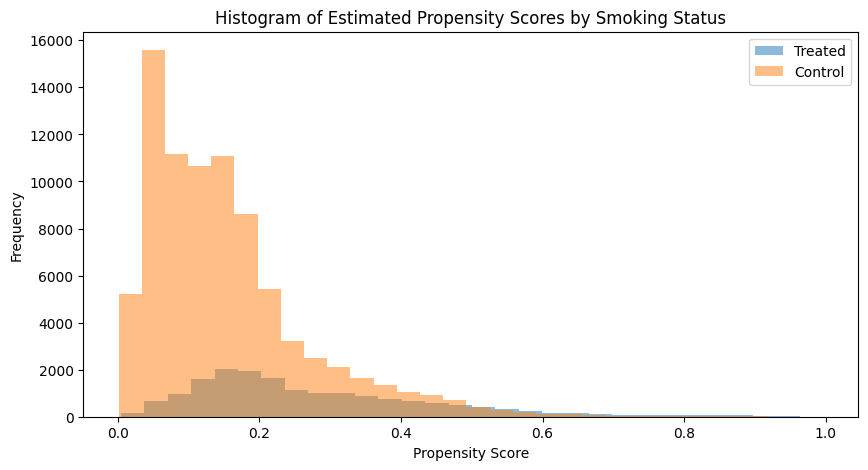

<Figure size 600x400 with 0 Axes>

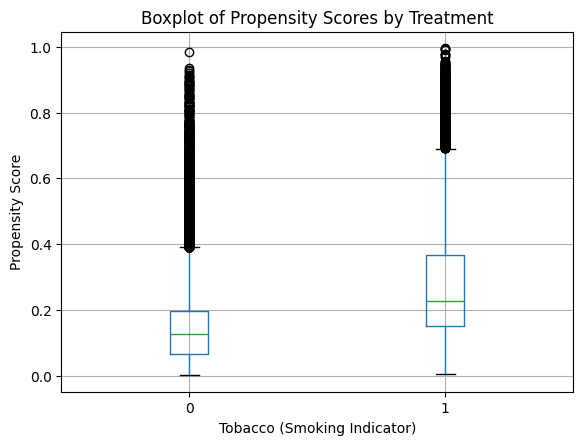

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(data.loc[data["tobacco"]==1, "pscore"], bins=30, alpha=0.5, label="Treated")
plt.hist(data.loc[data["tobacco"]==0, "pscore"], bins=30, alpha=0.5, label="Control")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.title("Histogram of Estimated Propensity Scores by Smoking Status")
plt.legend()
plt.show()

# Alternatively, a boxplot can be produced:
plt.figure(figsize=(6, 4))
data.boxplot(column="pscore", by="tobacco")
plt.title("Boxplot of Propensity Scores by Treatment")
plt.suptitle("")  # Suppress the automatic title
plt.xlabel("Tobacco (Smoking Indicator)")
plt.ylabel("Propensity Score")
plt.show()

In summary, the groups have some overlap in their propensity scores, but the smokers generally have higher scores, reflecting the differences in observed covariates. This partial overlap is crucial for propensity-score-based methods to be valid but also highlights that some observations may lie in regions with few or no comparable matches.

# Question 7

In [28]:
# Determine common support limits:
ps_treated = data.loc[data["tobacco"] == 1, "pscore"]
ps_control = data.loc[data["tobacco"] == 0, "pscore"]

common_lower = max(ps_treated.min(), ps_control.min())
common_upper = min(ps_treated.max(), ps_control.max())

print("\nCommon support range for propensity scores: [{:.3f}, {:.3f}]".format(common_lower, common_upper))

# Identify observations outside the common support:
data["in_support"] = data["pscore"].between(common_lower, common_upper)
num_dropped = len(data) - data["in_support"].sum()
print("Number of observations dropped by imposing overlap:", num_dropped)

# Restrict the data to observations within the common support for subsequent analyses:
data_overlap = data[data["in_support"]].copy()


Common support range for propensity scores: [0.005, 0.984]
Number of observations dropped by imposing overlap: 283


We drop individuals whose propensity scores don’t overlap between smokers and non-smokers because we can’t reliably compare them—they have no similar counterparts in the other group. Keeping these people would force us to make unrealistic comparisons and could bias our estimate.

Once we’ve removed these observations, we are not estimating the population Average Treatment Effect (ATE) anymore. Instead, we’re estimating the ATE for the subgroup of individuals who are similar enough (in terms of observed characteristics) to have overlapping propensity scores, often called the “ATE on the common support.” This effect applies specifically to individuals for which we can make meaningful comparisons.

# Question 8

In [29]:
def weighted_mean(series, weights):
    return np.average(series, weights=weights)

# Define weights: For treated: 1/pscore, for control: 1/(1-pscore)
data_overlap["w_ipw"] = np.where(data_overlap["tobacco"]==1,
                                 1/data_overlap["pscore"],
                                 1/(1-data_overlap["pscore"]))

weighted_rows = []
for var in covariates:
    # For treated and control, compute weighted means:
    treated = data_overlap[data_overlap["tobacco"]==1]
    control = data_overlap[data_overlap["tobacco"]==0]
    mean_treated = weighted_mean(treated[var].dropna(), treated.loc[treated[var].notnull(), "w_ipw"])
    mean_control = weighted_mean(control[var].dropna(), control.loc[control[var].notnull(), "w_ipw"])
    diff = mean_treated - mean_control
    # A formal weighted t-test is more involved; here we simply note the differences.
    weighted_rows.append({
        "Variable": var,
        "Weighted Mean (Treated)": mean_treated,
        "Weighted Mean (Control)": mean_control,
        "Difference": diff
    })

weighted_balance = pd.DataFrame(weighted_rows)
print("\n--- Q8: Weighted Balance Table (Using IPW Weights) ---")
print(weighted_balance)


--- Q8: Weighted Balance Table (Using IPW Weights) ---
    Variable  Weighted Mean (Treated)  Weighted Mean (Control)  Difference
0      dmage                27.201417                27.064984    0.136433
1     dmage2               774.931276               763.298670   11.632606
2     dmeduc                12.698871                12.923597   -0.224726
3     mblack                 0.129010                 0.114032    0.014978
4    motherr                 0.015050                 0.013144    0.001906
5    mhispan                 0.031061                 0.026107    0.004954
6       dmar                 0.232141                 0.228979    0.003162
7   foreignb                 0.049544                 0.044291    0.005253
8      dfage                29.438216                29.463302   -0.025085
9     dfeduc                12.730701                13.017946   -0.287245
10    fblack                 0.139835                 0.123222    0.016613
11   fotherr                 0.011092       

Closer Means:

After reweighting, the differences in the means of covariates between the treated and control groups are much smaller compared to the unweighted differences from Problem 3. For example, the unweighted difference in dmage was around –1.82, but after weighting, it shrinks to about 0.14.

Improved Balance:

This reduction in differences indicates that the propensity score weighting has successfully balanced the observed covariates between the two groups, making them more comparable.

Statistical Significance:

Although the code does not formally test for statistical significance, the small magnitude of the differences suggests that few (if any) of the 30 covariate differences would remain statistically significant after reweighting.

Overall Conclusion:

The propensity score helps to balance the covariates, thus reducing potential bias in estimating the treatment effect.

# Question 9

In [30]:
# For each treated observation, find the closest control based on the absolute difference in pscore.
treated_data = data_overlap[data_overlap["tobacco"] == 1].reset_index(drop=True)
control_data = data_overlap[data_overlap["tobacco"] == 0].reset_index(drop=True)

# Use NearestNeighbors on the pscore
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control_data[["pscore"]])
distances, indices = nn.kneighbors(treated_data[["pscore"]])

# Get matched control outcomes:
matched_controls = control_data.iloc[indices.flatten()]
# Compute ATE as the average difference in outcome (birth weight) between treated and matched controls:
ate_matching_ps = (treated_data["dbirwt"].values - matched_controls["dbirwt"].values).mean()
print("\n--- Q9: Nearest-Neighbor Matching on pscore ---")
print("Estimated ATE (Matching on pscore): {:.3f}".format(ate_matching_ps))



--- Q9: Nearest-Neighbor Matching on pscore ---
Estimated ATE (Matching on pscore): -228.851


Drawbacks of matching (vs. weighting):

Limited data use: Matching typically pairs each treated unit with only one or a few control units, ignoring information from unmatched observations. Weighting, on the other hand, uses all available data.

Matching quality issues:

Matching quality depends on how closely treated and control observations resemble each other. Poor matches can lead to biased estimates.

Sensitivity to method choices: 

Matching estimates can be sensitive to decisions such as the distance metric or the number of matches selected.

Weighting approaches typically avoid these issues by utilizing all observations and adjusting more flexibly, potentially producing more robust estimates.

Question 10

In [10]:
cov_matrix = np.cov(data_overlap[covariates].dropna().values, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Define a function to compute Mahalanobis distance between two vectors:
def mahalanobis(u, v, VI):
    delta = u - v
    return np.sqrt(np.dot(np.dot(delta, VI), delta.T))

# For each treated observation, find the closest control using Mahalanobis distance.
matched_outcomes = []
for idx, treated_row in treated_data.iterrows():
    treated_cov = treated_row[covariates].values.astype(float)
    distances = control_data[covariates].apply(lambda row: mahalanobis(treated_cov, row.values.astype(float), inv_cov_matrix), axis=1)
    min_idx = distances.idxmin()
    matched_outcome = control_data.loc[min_idx, "dbirwt"]
    matched_outcomes.append(matched_outcome)
matched_controls_maha = pd.Series(matched_outcomes, index=treated_data.index)
ate_matching_cov = (treated_data["dbirwt"] - matched_controls_maha).mean()
print("\n--- Q10: Matching on All Covariates (Mahalanobis Distance) ---")
print("Estimated ATE (Matching on all covariates): {:.3f}".format(ate_matching_cov))
print("Advantage of p-score matching: reduced dimensionality; disadvantage: potential loss of covariate detail.")



--- Q10: Matching on All Covariates (Mahalanobis Distance) ---
Estimated ATE (Matching on all covariates): -241.878
Advantage of p-score matching: reduced dimensionality; disadvantage: potential loss of covariate detail.


Advantages and Disadvantages of Matching on Propensity Scoring

Advantage: 

Matching on the propensity score simplifies the matching process by reducing multiple covariates into a single score, solving the “curse of dimensionality.”

Disadvantage: 

Propensity-score matching may overlook important differences in individual covariates, potentially creating less precise matches compared to matching directly on all covariates.

Question 11

In [31]:
model_ipw = sm.WLS(data_overlap["dbirwt"], sm.add_constant(data_overlap["tobacco"]),
                     weights=data_overlap["w_ipw"]).fit()
print("\n--- Q11: Weighted Regression (Treatment Only) ---")
print(model_ipw.summary())


--- Q11: Weighted Regression (Treatment Only) ---
                            WLS Regression Results                            
Dep. Variable:                 dbirwt   R-squared:                       0.039
Model:                            WLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4083.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:24:59   Log-Likelihood:            -7.8862e+05
No. Observations:               99717   AIC:                         1.577e+06
Df Residuals:                   99715   BIC:                         1.577e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

This weighted regression method adjusts the data to ensure that smokers and non-smokers are similar in their observed characteristics. After this adjustment, we find that maternal smoking reduces birth weight by about 232 grams on average. Although smoking only explains a small part of the total variation in birth weight, the effect we find is statistically significant and robust.

Question 12

In [32]:
formula_ipw = "dbirwt ~ tobacco + " + " + ".join(covariates)
model_ipw_cov = sm.WLS.from_formula(formula_ipw, data=data_overlap,
                                    weights=data_overlap["w_ipw"]).fit()
print("\n--- Q12: Weighted Regression with Covariates ---")
print(model_ipw_cov.summary())



--- Q12: Weighted Regression with Covariates ---
                            WLS Regression Results                            
Dep. Variable:                 dbirwt   R-squared:                       0.157
Model:                            WLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     597.5
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:25:02   Log-Likelihood:            -7.8212e+05
No. Observations:               99717   AIC:                         1.564e+06
Df Residuals:                   99685   BIC:                         1.565e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

The main advantage of the ATE estimate in Question 12 compared to Question 11 is that by including covariates, we further reduce potential bias due to any remaining imbalance, leading to a more accurate and precise estimate. In other words, it combines weighting with direct regression adjustment, better controlling for confounding factors and improving the reliability of our estimate.

# Question 13

(a) Among the estimates:

OLS regression (Q2): -232 grams

Matching on p-score (Q9): -229 grams

Weighted regression with covariates (Q12): -223 grams

I trust the weighted regression with covariates (Q12) the most, as it best controls for confounding by combining weighting and regression adjustments.

(b) Interpretation of preferred estimate (Q12):

Maternal smoking during pregnancy reduces infant birth weight by roughly 223 grams, on average, among mothers with similar characteristics.

(c) Assumptions for causality:

To interpret this as causal, we assume:

Unconfoundedness:

No unobserved factors influence both smoking and birth weight.

Overlap (common support): 

Every type of mother (covariate profile) can plausibly be both a smoker or non-smoker.

# Question 14:

In [35]:
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
print("\n--- Q14: A.) Quantile Regression (Unweighted) ---")
qte_results = {}
for q in quantiles:
    mod = QuantReg(data["dbirwt"], sm.add_constant(data["tobacco"]))
    res = mod.fit(q=q)
    qte_results[q] = res.params["tobacco"]
    print("Quantile {:.0%}: Coefficient = {:.3f}".format(q, res.params["tobacco"]))
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
import numpy as np
from scipy.optimize import minimize
print("\n--- Q14: B.) ---")

# Prepare data for weighted quantile regression (overlap sample)
y = data_overlap["dbirwt"].values
X = sm.add_constant(data_overlap["tobacco"]).values  # [1, tobacco]
weights = data_overlap["w_ipw"].values
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]

def weighted_quantile_loss(beta, X, y, tau, weights):
    """
    Weighted quantile loss function for optimization.
    beta: Coefficients [intercept, treatment]
    tau: Quantile (e.g., 0.5 for median)
    """
    residuals = y - X.dot(beta)
    loss = np.sum(weights * np.where(residuals >= 0, tau * residuals, (tau - 1) * residuals))
    return loss

# Store results
qte_results = {}

for tau in quantiles:
    # Initial guess: coefficients from unweighted quantile regression
    mod_init = QuantReg(y, X).fit(q=tau)
    beta_init = mod_init.params
    
    # Minimize the weighted loss
    result = minimize(
        fun=weighted_quantile_loss,
        x0=beta_init,
        args=(X, y, tau, weights),
        method='L-BFGS-B',  # Use Newton-CG for optimization
    )
    
    if result.success:
        qte = result.x[1]  # Coefficient for 'tobacco'
        qte_results[tau] = qte
        print(f"Quantile {tau:.0%}: ATE = {qte:.3f}")
    else:
        print(f"Optimization failed for tau = {tau}")

# Output results
print("\n--- Manual Weighted QTEs (IPW) ---")
for tau, ate in qte_results.items():
    print(f"τ = {tau:.0%}: {ate:.3f}")



--- Q14: A.) Quantile Regression (Unweighted) ---
Quantile 10%: Coefficient = -283.000
Quantile 25%: Coefficient = -263.000
Quantile 50%: Coefficient = -259.000
Quantile 75%: Coefficient = -256.000
Quantile 90%: Coefficient = -255.000

--- Q14: B.) ---
Quantile 10%: ATE = -252.187
Quantile 25%: ATE = -253.320
Quantile 50%: ATE = -214.547
Quantile 75%: ATE = -235.576
Quantile 90%: ATE = -226.000

--- Manual Weighted QTEs (IPW) ---
τ = 10%: -252.187
τ = 25%: -253.320
τ = 50%: -214.547
τ = 75%: -235.576
τ = 90%: -226.000


# IPW-Weighted Quantile Regression for Quantile Treatment Effects (QTEs)

## Setup

Let $T_i \in \{0,1\}$ denote the treatment indicator (e.g., maternal smoking), and let $Y_i$ be the observed outcome (e.g., infant birth weight). Let $X_i$ be a vector of observed covariates, and define the propensity score as

$$
\pi(X_i) = \Pr(T_i = 1 \mid X_i).
$$

We assume unconfoundedness:

$$
\{Y_i(0),\, Y_i(1)\} \perp T_i \mid X_i,
$$

and common support:

$$
0 < \pi(X_i) < 1 \quad \text{for all } i.
$$

## Inverse Probability Weights

Define the inverse probability weights (IPW) as

$$
w_i = \frac{T_i}{\pi(X_i)} + \frac{1-T_i}{1-\pi(X_i)}.
$$

These weights re-balance the sample so that the distribution of covariates for treated and control groups mimics that of a randomized experiment.

## Unconditional Quantile Treatment Effects (QTEs)

Let 
$$
Q_\tau(Y(1))
$$
and 
$$
Q_\tau(Y(0))
$$
denote the $\tau$-th unconditional quantiles of the potential outcomes under treatment and control, respectively. The Quantile Treatment Effect (QTE) at quantile $\tau$ is then defined as

$$
\mathrm{QTE}(\tau) = Q_\tau(Y(1)) - Q_\tau(Y(0)).
$$

## Weighted Quantile Regression Loss

To estimate $\mathrm{QTE}(\tau)$, we run a weighted quantile regression of $Y_i$ on a constant and $T_i$ by minimizing the following objective:

$$
\min_{\beta_0,\,\beta_1} \sum_{i=1}^n w_i \, \rho_\tau \Bigl(Y_i - \bigl[\beta_0 + \beta_1 T_i\bigr]\Bigr),
$$

where $\rho_\tau(u)$ is the check function defined by

$$
\rho_\tau(u) = u \left(\tau - \mathbf{1}[u < 0]\right).
$$

The coefficient $\widehat{\beta}_1$ from this minimization is an estimate of $\mathrm{QTE}(\tau)$.

## Interpretation

By reweighting each observation with $w_i$, we obtain estimates of the unconditional quantiles of $Y(1)$ and $Y(0)$ from the observed data. The weighted quantile regression effectively estimates:

$$
Q_\tau(Y(1)) = \inf\Biggl\{ q : \frac{1}{n}\sum_{i=1}^{n} w_i \, \mathbf{1}\bigl[T_i=1 \text{ and } Y_i \le q\bigr] \ge \tau \Biggr\},
$$

and similarly for $Q_\tau(Y(0))$. Thus, the difference

$$
\widehat{\beta}_1 \approx Q_\tau(Y(1)) - Q_\tau(Y(0))
$$

represents the causal effect of the treatment at the $\tau$-th quantile of the outcome distribution, provided that unconfoundedness and common support hold.

## Summary

- We estimate the propensity score $\pi(X_i)$ and compute the weights

  $$
  w_i = \frac{T_i}{\pi(X_i)} + \frac{1-T_i}{1-\pi(X_i)}.
  $$

- We run a weighted quantile regression by minimizing

  $$
  \sum_{i=1}^n w_i \, \rho_\tau\Bigl(Y_i - [\beta_0 + \beta_1 T_i]\Bigr).
  $$

- The estimated coefficient $\widehat{\beta}_1$ is an estimate of the Quantile Treatment Effect:

  $$
  \mathrm{QTE}(\tau) = Q_\tau(Y(1)) - Q_\tau(Y(0)).
  $$

14 (a) Conditions for Unweighted Quantile Regression Estimates (QTE):

The coefficients from the unweighted quantile regressions represent causal Quantile Treatment Effects (QTEs) only under the unconfoundedness assumption. Specifically, this assumption states that, conditional on observed characteristics, maternal smoking is independent of potential birth weight outcomes. Under this assumption, quantile differences in observed birth weights between smokers and non-smokers reflect the causal impact of smoking at each quantile of the distribution.

14 (b) Weighted Quantile Treatment Effects (IPW estimates):

Estimated Weighted QTEs:

10% quantile: -252 grams

25% quantile: -253 grams

50% quantile (median): -214 grams

75% quantile: -235 grams

90% quantile: -226 grams

Interpretation (Context of Application):

These weighted QTEs measure how maternal smoking affects infant birth weights across different points of the birth-weight distribution. Specifically, the results show that smoking consistently lowers infant birth weight throughout the entire distribution, with somewhat stronger negative impacts observed at lower quantiles (e.g., 10% and 25%), suggesting that maternal smoking disproportionately harms lighter infants.

Effect Across Quantiles:

The consistency of the estimated effects (around -214 to -253 grams) indicates a robust negative effect of maternal smoking across the entire birth-weight distribution, with slightly greater harm inflicted upon infants who are already at the lower end of the birth-weight spectrum.

# Question 15:

Heckman By Hand (Python didn't have it in Statsmodel)

### Explanation of the Heckman Code in Mathematical Terms

The code performs the following steps to correct for selection bias using a Heckman two-step approach:

1. **Selection Equation via Probit:**

   The code first estimates a probit model for the treatment indicator (smoking) using a set of covariates. Mathematically, this is expressed as:
   
   $$
   T_i^* = \mathbf{Z}_i' \gamma + \epsilon_i, \quad \epsilon_i \sim N(0,1),
   $$
   
   where:
   - $\mathbf{Z}_i$ is the vector of covariates (e.g., alcohol, drink, first, dmar, motherr, fblack, dmeduc, dmage, dfeduc),
   - $\gamma$ is the parameter vector to be estimated,
   - $\epsilon_i$ is the error term.
   
   The observed binary treatment is defined as:
   
   $$
   T_i = \begin{cases}
   1, & \text{if } T_i^* > 0, \\
   0, & \text{otherwise.}
   \end{cases}
   $$
   
   Therefore, the probability of receiving treatment is:
   
   $$
   \Pr(T_i = 1 \mid \mathbf{Z}_i) = \Phi(\mathbf{Z}_i' \gamma),
   $$
   
   where $\Phi(\cdot)$ is the standard normal cumulative distribution function (CDF).

2. **Computation of the Inverse Mills Ratio (IMR):**

   After estimating the parameters $\hat{\gamma}$, the model predicts the probability for each observation:
   
   $$
   \hat{p}_i = \Phi(\mathbf{Z}_i' \hat{\gamma}).
   $$
   
   The Inverse Mills Ratio is then computed as:
   
   $$
   \hat{\lambda}_i = \frac{\phi(\mathbf{Z}_i' \hat{\gamma})}{\Phi(\mathbf{Z}_i' \hat{\gamma})},
   $$
   
   where $\phi(\cdot)$ is the standard normal probability density function (PDF). This ratio serves as a correction factor that captures the selection hazard due to non-random treatment assignment.

3. **Outcome Equation with the IMR Correction:**

   The outcome of interest (birth weight, $Y_i$) is modeled as:
   
   $$
   Y_i = \mathbf{X}_i' \beta + \delta\, T_i + u_i,
   $$
   
   where:
   - $\mathbf{X}_i$ is the vector of covariates included in the outcome equation,
   - $\beta$ is the corresponding parameter vector,
   - $\delta$ is the effect of the treatment,
   - $u_i$ is the error term.
   
   Since the treatment is not randomly assigned, $u_i$ and the error term $\epsilon_i$ in the selection equation may be correlated. To correct for this, the IMR is added to the outcome regression:
   
   $$
   Y_i = \mathbf{X}_i' \beta + \delta\, T_i + \rho\, \sigma_u\, \hat{\lambda}_i + \nu_i,
   $$
   
   where:
   - $\rho$ is the correlation between $u_i$ and $\epsilon_i$,
   - $\sigma_u$ is the standard deviation of $u_i$,
   - $\nu_i$ is an error term with zero mean that is uncorrelated with $\mathbf{X}_i$.
   
   Including $\hat{\lambda}_i$ as an additional regressor helps adjust for the selection bias.

---

**Summary:**

- **Probit Stage:** Estimate $\hat{\gamma}$ by modeling
  $$
  \Pr(T_i = 1 \mid \mathbf{Z}_i) = \Phi(\mathbf{Z}_i' \gamma).
  $$
- **IMR Calculation:** For each observation, compute
  $$
  \hat{\lambda}_i = \frac{\phi(\mathbf{Z}_i' \hat{\gamma})}{\Phi(\mathbf{Z}_i' \hat{\gamma})}.
  $$
- **Outcome Regression:** Estimate
  $$
  Y_i = \mathbf{X}_i' \beta + \delta\, T_i + \rho\, \sigma_u\, \hat{\lambda}_i + \nu_i,
  $$
  using OLS with robust standard errors.

This two-step procedure corrects for the non-random selection into treatment, providing a less biased estimate of the effect of smoking on birth weight.

In [36]:
import statsmodels.formula.api as smf
from scipy.stats import norm
import pandas as pd

# Assuming 'data' is your DataFrame
selection_formula = "tobacco ~ alcohol + drink + first + dmar + motherr + fblack + dmeduc + dmage + dfeduc"
probit_model = smf.probit(selection_formula, data=data).fit()
print("\n--- Probit Model (Selection Equation) ---")
print(probit_model.summary())

# Calculate Inverse Mills Ratio
selection_predict = probit_model.predict(data)
data['imr'] = norm.pdf(selection_predict) / norm.cdf(selection_predict)

# Outcome equation with IMR
outcome_formula = (
    "dbirwt ~ tobacco + dmage + dmage2 + dmeduc + mblack + motherr + mhispan + "
    "dmar + foreignb + dfage + dfeduc + fblack + fotherr + fhispan + alcohol + drink + "
    "adequac2 + adequac3 + tripre0 + tripre2 + tripre3 + nprevist + first + dlivord + "
    "disllb + pre4000 + plural + diabete + anemia + cardiac + chyper + imr"
)
ols_model = smf.ols(outcome_formula, data=data).fit(cov_type='HC3')
print("\n--- OLS Model with IMR (Outcome Equation) ---")
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.412530
         Iterations 7

--- Probit Model (Selection Equation) ---
                          Probit Regression Results                           
Dep. Variable:                tobacco   No. Observations:               100000
Model:                         Probit   Df Residuals:                    99990
Method:                           MLE   Df Model:                            9
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                  0.1080
Time:                        18:25:52   Log-Likelihood:                -41253.
converged:                       True   LL-Null:                       -46250.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0639      0.040     26.344      0.000       0.98


(a) Control Function vs. IV Approach

Control Function (Heckman)

Pros: Corrects explicitly for selection bias; estimates magnitude and direction of bias.

Cons: Strong distributional assumptions (normality), requires valid exclusion restrictions.

Instrumental Variable (IV)

Pros: Uses external variation to isolate causal effect; fewer distributional assumptions.

Cons: Difficult to find credible instruments; estimates typically less precise.

---

(b) Validity of Exclusion Restrictions (“Preterm” and “Deadkids”)

These two variables are valid exclusions if they:

Predict maternal smoking (significant in selection equation).

Affect birth weight only through their effect on smoking (no direct impact).

---

(c) Heckman Two-Step vs. Maximum Likelihood (ML) Estimates

Two-Step (Heckman):

Pros: Simpler, intuitive.

Cons: Less efficient, sensitive to assumptions.

Effect Estimate: -231.48 grams (SE=4.82, 95% CI: [-240.94, -222.03]).

ML Approach:

Pros: More efficient (if correctly specified).

Cons: Computationally intensive, sensitive to misspecification.

Estimated “Rho”:

Coefficient: ~384.03 (SE=127.05), significantly different from zero (p=0.003).

Implication: Significant selection bias; mothers likely to smoke also have higher unobserved factors positively affecting birth weight.

---

(d) Credibility of Results from Selection Model

Credibility hinges on:

Validity of exclusion restrictions (preterm, deadkids).

Correct specification and normality assumptions.

If confident in exclusions, the selection model is trustworthy. Otherwise, propensity score (selection-on-observables) methods from Question 13 may be preferred due to fewer and weaker assumptions.

---

(e) Proposed Instrument and Interpretation (IV with Heterogeneity)

Proposed Instrument: State-level cigarette taxes or pregnancy smoking bans.

Average Treatment Effect Estimated: Local Average Treatment Effect (LATE)—effect on mothers who smoke less due to higher taxes or bans (the “compliers”).

Key Assumptions:

Exclusion Restriction: Tax policy affects birth weight only through smoking behavior.

Monotonicity: Instrument consistently reduces (or does not increase) smoking likelihood for all affected mothers.

---

# Question 16: 
Derivation of 
$
E[Y(1)] = E\!\left[\frac{T \cdot Y}{\pi(X)}\right]
$

where:
- $Y(1)$ is the potential outcome under treatment,  
- $T$ is the treatment indicator,  
- $Y$ is the observed outcome,  
- $\pi(X) = \Pr(T=1 \mid X)$ is the propensity score.
---

## Step 1: Law of Iterated Expectations

We begin with the law of iterated expectations:
$$
E[Y(1)] = E\!\left[E\left(Y(1) \mid X\right)\right].
$$

---

## Step 2: Unconfoundedness Assumption

Under the unconfoundedness assumption, the potential outcome \(Y(1)\) is independent of the treatment \(T\) given \(X\). Thus, we have:
$$
E\left(Y(1) \mid X\right) = E\left(Y(1) \mid T=1, X\right).
$$
Since for treated individuals \(Y = Y(1)\), it follows that:
$$
E\left(Y(1) \mid X\right) = E\left(Y \mid T=1, X\right).
$$

---

## Step 3: Relating to Observed Data

We can express the conditional expectation of \(Y\) given \(T=1\) and \(X\) as:
$$
E\left(Y \mid T=1, X\right) = \frac{E\left(T \cdot Y \mid X\right)}{\Pr(T=1 \mid X)} = \frac{E\left(T \cdot Y \mid X\right)}{\pi(X)}.
$$
This holds because when \(T=1\), we have \(T \cdot Y = Y\), and for a binary variable \(T\):
$$
E\left(T \cdot Y \mid X\right) = \Pr(T=1 \mid X) \, E\left(Y \mid T=1, X\right).
$$

---

## Step 4: Substitute and Conclude

Substitute the result from Step 3 into the iterated expectation:
$$
E[Y(1)] = E\!\left[E\left(Y(1) \mid X\right)\right] = E\!\left[\frac{E\left(T \cdot Y \mid X\right)}{\pi(X)}\right].
$$
By the law of iterated expectations, this simplifies to:
$$
E[Y(1)] = E\!\left[\frac{T \cdot Y}{\pi(X)}\right].
$$

This completes the derivation.

# Question 18

a.)

The paper “Instrumental Variables and the Search for Identification: From Supply and Demand to Natural Experiments” by Angrist and Krueger (2001) offers an engaging overview of instrumental variables (IV) methods, exploring their evolution from early applications in estimating supply and demand elasticities to contemporary uses in causal inference through natural experiments. The authors highlight IV’s strength in addressing simultaneity bias, omitted variables, and measurement error, providing clear historical examples, such as Milton Friedman’s study of the consumption function, where grouping data by city helped overcome noisy measurements of permanent income. They emphasize the importance of Two-Stage Least Squares (2SLS), which efficiently combines multiple instruments to yield consistent—but not necessarily unbiased—estimates, noting explicitly that consistency improves with larger datasets.

A key insight in the paper is the Local Average Treatment Effect (LATE), which shows that IV methods specifically identify causal effects for individuals whose behavior is directly influenced by the instrument, such as draftees in a lottery system. Angrist and Krueger strongly advocate the use of natural experiments, like exploiting differences in schooling caused by birth timing and compulsory education laws, as these provide credible, quasi-random variation. They further recommend validating these instruments through careful reduced-form analyses—such as examining direct relationships between birth quarters and earnings—particularly emphasizing their importance when instruments might be weak.

The paper effectively balances theoretical depth with practical considerations. Angrist and Krueger stress that robust IV analyses rely not only on statistical techniques but also on thorough institutional understanding—such as knowing details about school entry laws or military draft regulations—to select credible instruments. They caution readers about the dangers of weak instruments, explaining how they bias IV estimates towards ordinary least squares (OLS), and encourage transparency through reduced-form checks. Moreover, they illustrate that comparing IV estimates with OLS results across different studies (e.g., returns to schooling or effects of class size) helps clarify when IV effectively corrects for omitted variable biases.

Overall, the authors successfully blend historical context, methodological clarity, and practical guidance, demonstrating that careful IV approaches rooted in real-world insights can meaningfully improve causal inference, especially in situations where controlled experiments are not possible.

b.) yes 